In [ ]:
import time
import sys
import itertools
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
#recall
#precision

from keras.models import Sequential
from keras.layers import Dense

from keras.utils import np_utils as npu

In [ ]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

import seaborn as sns
def create_numerics(data):
    # Get nominal columns
    nominal_cols = data.select_dtypes(include='object').columns.tolist()

    # Turn nominal to numeric
    for nom in nominal_cols:
        enc = LabelEncoder()
        enc.fit(data[nom])
        data[nom] = enc.transform(data[nom])
        
    return data

def prepare_data():
    data = pd.read_excel("data.xlsx")
    data = data.dropna()
    
    trojan_free = data.loc[data['Label']=="'Trojan Free'"].reset_index()    
    
    # balance the ratio between trojan free and infected of the same circuit category
    for i in range(len(trojan_free)):
        category_substring = trojan_free['Circuit'][i].replace("'",'')
        circuit_group = data[data['Circuit'].str.contains(category_substring)]
        
        df1 = circuit_group.iloc[0:1]
        
        if len(circuit_group) > 1:
            data = data.append([df1]*(len(circuit_group)-1), ignore_index=True)
    
    data.drop(columns=['Circuit'], inplace=True)

    data = create_numerics(data)
    
    data = shuffle(data, random_state=42)

    # Create correlation matrix
    corr_matrix = data.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                      k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

    # Drop features
    data = data.drop(data[to_drop], axis=1)
    
    y = pd.DataFrame(data["Label"]).values
    x = data.drop(["Label"], axis=1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    x = scaler.fit_transform(x)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
    
    return(x_train, x_test, y_train, y_test)

In [ ]:
# test_x and test_y is the data we are getting after preprocessing

def create_model(train_x, test_y):
    num_classes = test_y.shape[1]

    model = Sequential()

    model.add(Dense(15, input_dim=train_x.shape[1], activation='relu'))

    model.add(Dense(75, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['mse', 'accuracy'])
    return model



In [ ]:
def deep_learning_model1(train_x, test_x, train_y, test_y):
    """
    This function performs multiclass classification with a deep learning model(using multilayer_perceptron)
    """

    labels = test_y

    train_y = npu.to_categorical(train_y)
    test_y = npu.to_categorical(test_y)
    
    model = create_model(train_x, test_y)
    
    start = time.time()
    model.fit(train_x, train_y, epochs=50, batch_size=10, shuffle=False)
    end = time.time()
    
    y_pred = model.predict(test_x)
    predictions = np.argmax(y_pred, axis=1)

    correct_class = 0
    for i in range(len(labels)):
        if labels[i] == predictions[i]:
            correct_class += 1

    time_ = end - start
    accuracy = (correct_class / len(labels)) * 100

    print("### Deep Learning Model ###\n")
    print("Training lasted %.2f seconds" % time_)
    print("Accuracy = %.2f" % (accuracy))

    return(time_, accuracy)

In [ ]:
x_train, x_test, y_train, y_test = prepare_data()

dl_model_time, dl_model_accuracy = deep_learning_model1(x_train, x_test, y_train, y_test)


Epoch 1/50
212/212 [==============================] - 1s 1ms/step - loss: 0.6216 - mse: 0.2149 - accuracy: 0.7163
Epoch 2/50
212/212 [==============================] - 0s 1ms/step - loss: 0.5814 - mse: 0.1961 - accuracy: 0.7265
Epoch 3/50
212/212 [==============================] - 0s 1ms/step - loss: 0.5624 - mse: 0.1886 - accuracy: 0.7275
Epoch 4/50
212/212 [==============================] - 0s 1ms/step - loss: 0.5253 - mse: 0.1731 - accuracy: 0.7282
Epoch 5/50
212/212 [==============================] - 0s 1ms/step - loss: 0.4680 - mse: 0.1487 - accuracy: 0.8030
Epoch 6/50
212/212 [==============================] - 0s 1ms/step - loss: 0.4053 - mse: 0.1232 - accuracy: 0.8490
Epoch 7/50
212/212 [==============================] - 0s 1ms/step - loss: 0.3528 - mse: 0.1039 - accuracy: 0.8622
Epoch 8/50
212/212 [==============================] - 0s 1ms/step - loss: 0.3134 - mse: 0.0909 - accuracy: 0.8734
Epoch 9/50
212/212 [==============================] - 0s 2ms/step - loss: 0.2841 - mse: 

In [ ]:
def support_vector_machine(train_x, test_x, train_y, test_y):
    """
    This function performs classification with support vector machine
    """
    train_y = train_y.reshape((train_y.shape[0], ))
  
    classifier = SVC(kernel="rbf", C=10, gamma=1)

    start = time.time()
    classifier.fit(train_x, train_y)
    end = time.time()

    y_pred = classifier.predict(test_x)

    time_ = end - start
    accuracy = 100 * accuracy_score(test_y, y_pred)
    
    print("### SVM ###\n")
    print("Training lasted %.2f seconds" % time_)
    print("For C : ", 10, ", Gamma: ", 1, ", kernel = rbf",
          " => Accuracy = %.2f" % (accuracy))
        
    return(time_, accuracy)


In [ ]:
svm_time, svm_accuracy = support_vector_machine(x_train, x_test, y_train, y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

### SVM ###

Training lasted 0.21 seconds
For C :  10 , Gamma:  1 , kernel = rbf  => Accuracy = 77.31
(2118, 25)
(2118, 1)
(908, 25)
(908, 1)


In [ ]:
def logistic_regression(train_x, test_x, train_y, test_y):
    """
    This function performs classification with logistic regression.
    """
    train_y = train_y.reshape((train_y.shape[0], ))

    clf = LogisticRegression(random_state=0, solver='liblinear', max_iter=300,
                             multi_class='ovr')
    start = time.time()
    clf.fit(train_x, train_y)
    end = time.time()
    
    y_pred = clf.predict(test_x)

    time_ = end - start
    accuracy = 100 * accuracy_score(test_y, y_pred)

    print("### LR ###\n")
    print("Training lasted %.2f seconds" % time_)
    print("Accuracy = %.2f" % (accuracy))

    return(time_, accuracy)

In [ ]:
lr_time, lr_accuracy = logistic_regression(x_train, x_test, y_train, y_test)

### LR ###

Training lasted 0.01 seconds
Accuracy = 71.81


In [ ]:
def gradient_boosting(train_x, test_x, train_y, test_y):
  """
  This function performs classification with Gradient Boosting.
  """
  train_y = train_y.reshape((train_y.shape[0], ))
      
  clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=75)

  start = time.time()
  clf.fit(train_x, train_y)    
  end = time.time()

  y_pred = clf.predict(test_x)

  time_ = end - start
  accuracy = 100 * accuracy_score(test_y, y_pred)

  print("### GB ###\n")
  print("Training lasted %.2f seconds" % time_)
  print("Accuracy = %.2f" % (accuracy))

  return(time_, accuracy)


In [ ]:
grad_time, grad_accuracy = gradient_boosting(x_train, x_test, y_train, y_test)

### GB ###

Training lasted 0.15 seconds
Accuracy = 99.56


In [ ]:
def k_neighbors(train_x, test_x, train_y, test_y):
  """
  This function performs classification with k neighbors algorithm.
  """
  train_y = train_y.reshape((train_y.shape[0], ))
        
  clf = KNeighborsClassifier(n_neighbors=3)
  
  start = time.time()
  clf.fit(train_x, train_y)
  end = time.time()

  y_pred = clf.predict(test_x)

  time_ = end - start
  accuracy = 100 * accuracy_score(test_y, y_pred)

  print("### KNN ###\n")
  print("Training lasted %.2f seconds" % time_)
  print("Accuracy = %.2f" % (accuracy))

  return(time_, accuracy)


In [ ]:
knn_time, knn_accuracy = k_neighbors(x_train, x_test, y_train, y_test)

### KNN ###

Training lasted 0.02 seconds
Accuracy = 99.45


In [ ]:
def random_forest(train_x, test_x, train_y, test_y):
  """
  This function performs classification with random forest.
  """
  train_y = train_y.reshape((train_y.shape[0], ))
      
  clf = RandomForestClassifier(n_estimators=5, max_depth=5, random_state=1)
  
  start = time.time()
  clf.fit(train_x, train_y)    
  end = time.time()

  y_pred = clf.predict(test_x)

  time_ = end - start
  accuracy = 100 * accuracy_score(test_y, y_pred)

  print("### RF ###\n")
  print("Training lasted %.2f seconds" % time_)
  print("Accuracy = %.2f" % (accuracy))
#print("F1-score = ",f1_score(test_y, y_pred, average='macro')*100)

  return(time_, accuracy)

In [ ]:
rf_time, rf_accuracy = random_forest(x_train, x_test, y_train, y_test)

### RF ###

Training lasted 0.02 seconds
Accuracy = 99.01


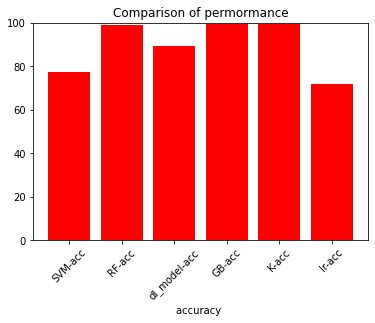

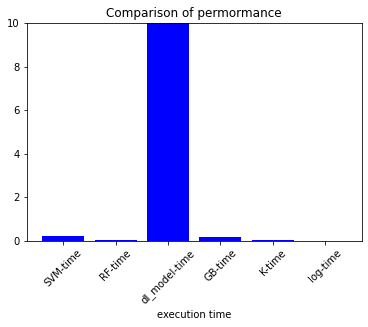

In [ ]:
accuracy = [svm_accuracy, rf_accuracy, dl_model_accuracy, grad_accuracy,
            knn_accuracy, lr_accuracy]
time_ = [svm_time, rf_time, dl_model_time, grad_time, knn_time, lr_time]

plt.ylim(0, 100)
plt.xlabel("accuracy ")
plt.title("Comparison of permormance")
l1, l2, l3, l4, l5, l6 = plt.bar(["SVM-acc", "RF-acc", "dl_model-acc",
                                            "GB-acc", "K-acc", "lr-acc"],
                                            accuracy)

plt.xticks(rotation=45)

l1.set_facecolor('r')
l2.set_facecolor('r')
l3.set_facecolor('r')
l4.set_facecolor('r')
l5.set_facecolor('r')
l6.set_facecolor('r')

plt.show()
plt.close('all')
plt.ylim(0, 10)
plt.xlabel("execution time")
plt.title("Comparison of permormance")
c1, c2, c3, c4, c5, c6 = plt.bar(["SVM-time", "RF-time", "dl_model-time",
                                            "GB-time", "K-time", "log-time"],
                                            time_)
c1.set_facecolor('b')
c2.set_facecolor('b')
c3.set_facecolor('b')
c4.set_facecolor('b')
c5.set_facecolor('b')
c6.set_facecolor('b')
plt.xticks(rotation=45)
plt.show()        

